# Imports

In [1]:
import os
import sys 
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout

from scipy import stats
from datetime import datetime, date

from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings

warnings.simplefilter('ignore')
init_notebook_mode(connected=True)

sns.set()
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                   parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                   low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


# Exploratory data analysis

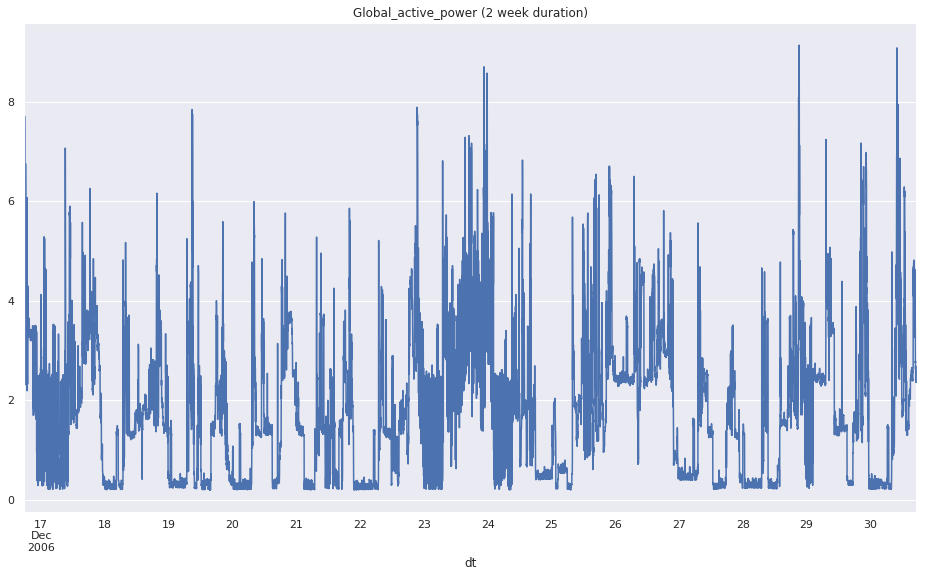

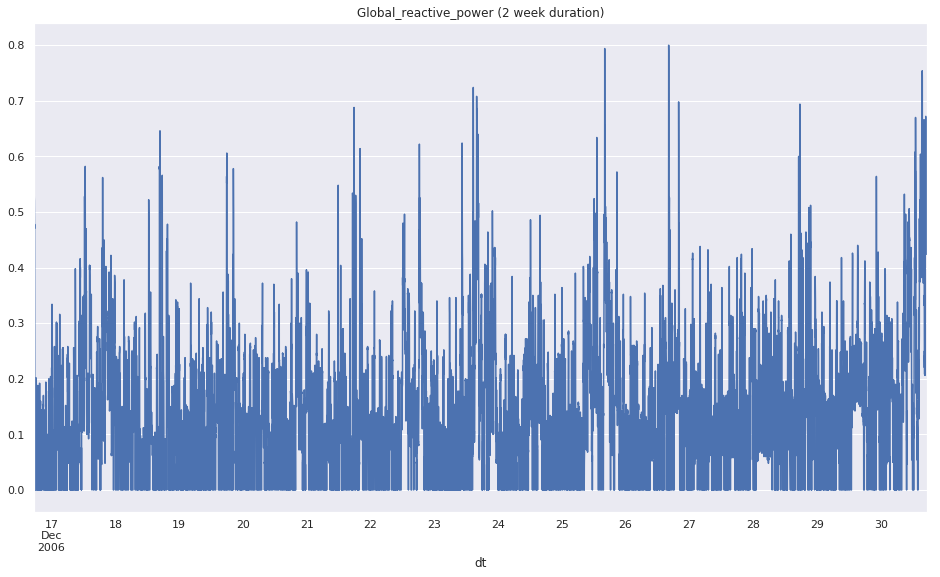

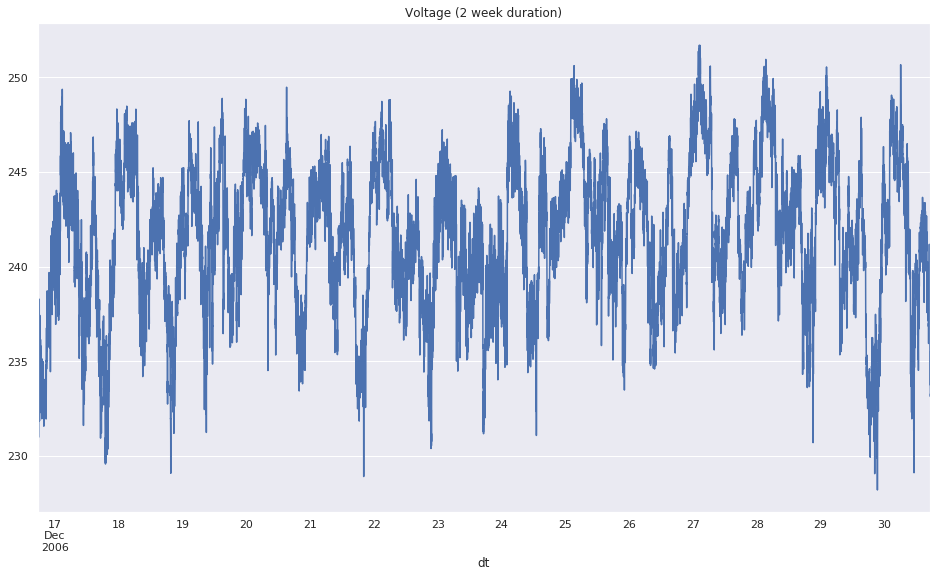

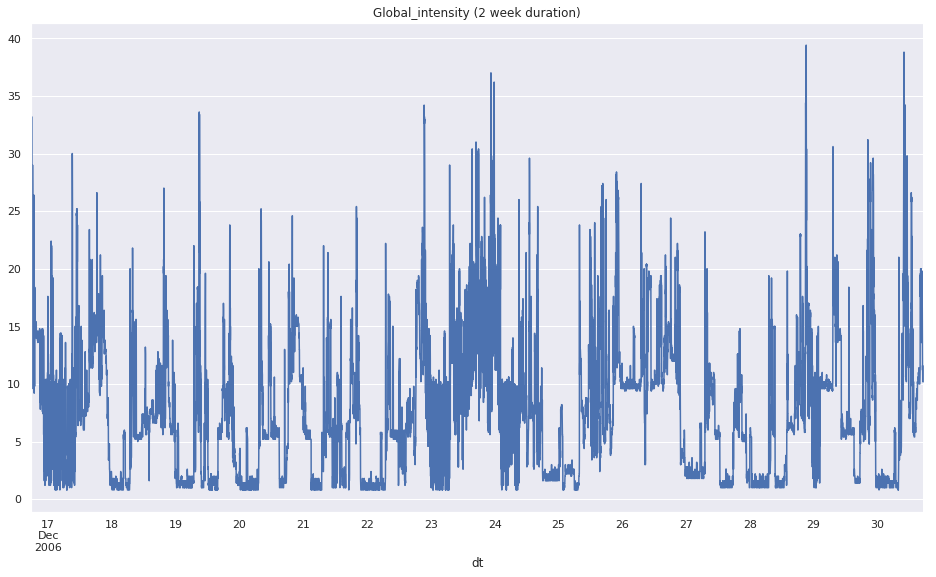

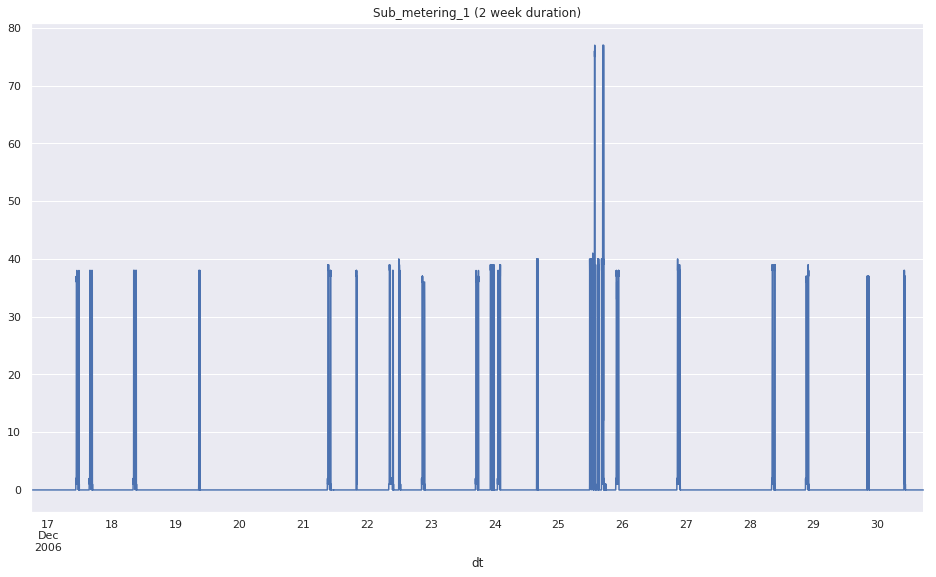

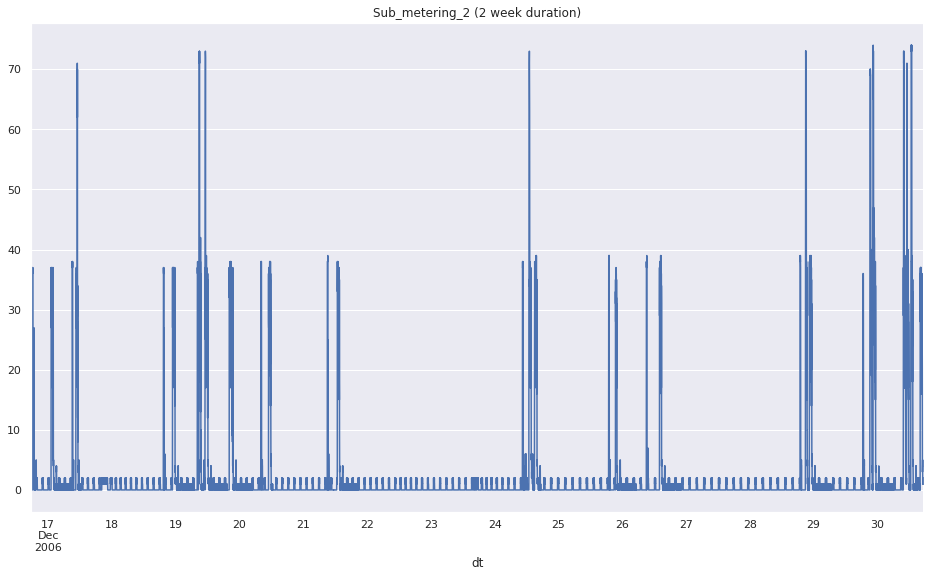

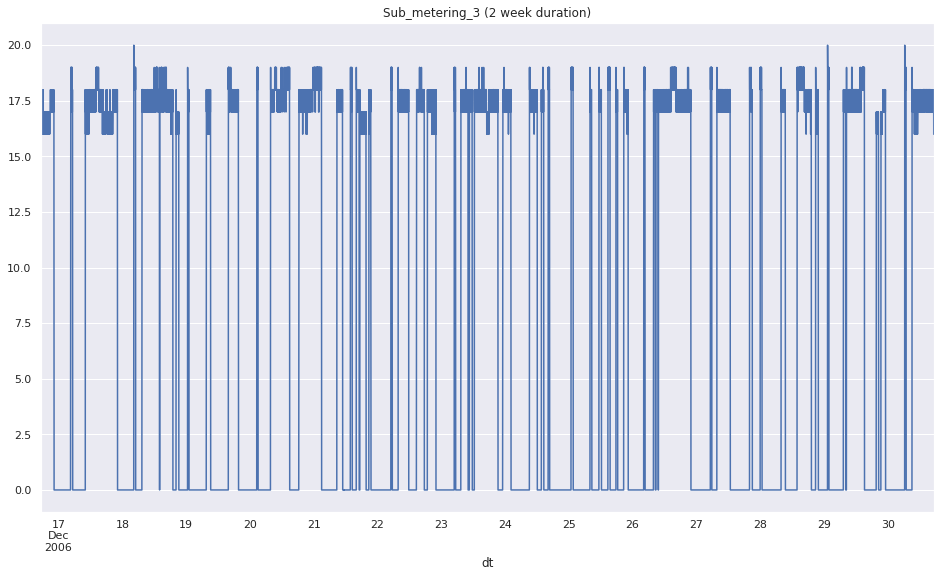

In [5]:
for column in data.columns:
    plt.figure(figsize=(16, 9))
    plt.title(f'{column} (2 week duration)')
    data[column][:60*24*14].plot()
    plt.show()

Для простоты будем работать с **дневным** потреблением электричества (*Global active power*), посмотрим внимательнее на данные.

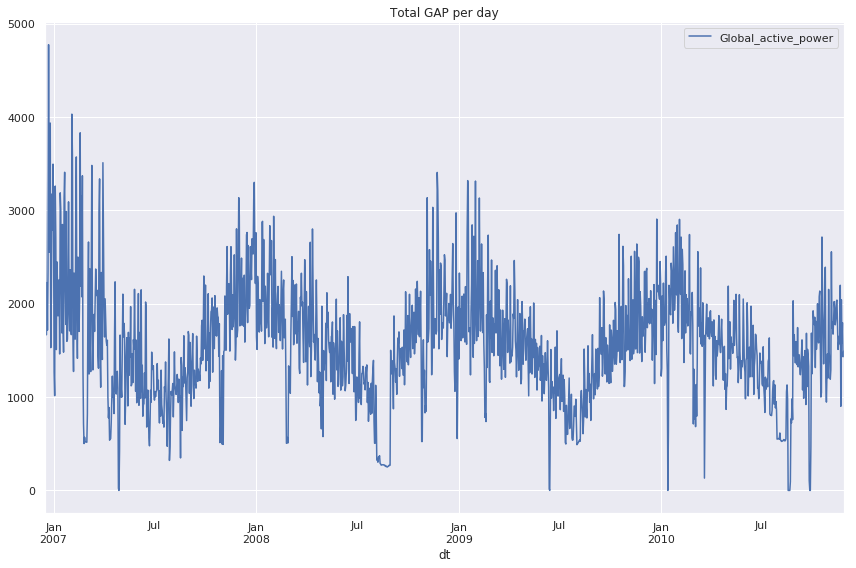

In [6]:
data[['Global_active_power']].resample('D').apply(sum).plot(title='Total GAP per day', figsize=(12, 8)) 
plt.tight_layout()
plt.show()

Видим несколько пиков в нуле. Достаточно странное поведение, учитывая что мы суммировали все возможные значения мощности за день. Посмотрим на изначальные данные.

In [7]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

В данных пропусков примерно на 18 дней, интерполируем пропущенные значения.

In [8]:
data.interpolate(method='time', inplace=True)
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
data['Global_active_power'].describe()

count    2.075259e+06
mean     1.090280e+00
std      1.052628e+00
min      7.600000e-02
25%      3.100000e-01
50%      6.140000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

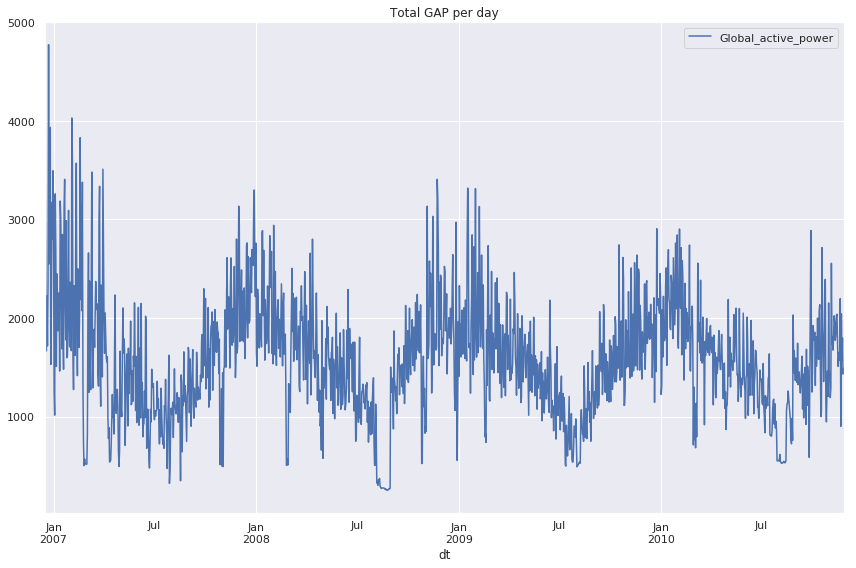

In [10]:
data[['Global_active_power']].resample('D').apply(sum).plot(title='Total GAP per day', figsize=(12, 8)) 
plt.tight_layout()
plt.show()

# Простые бейзлайн решения для прогнозирования рядов

## Предыдущий день

In [11]:
def plot_prediction(gt, pred, figsize=(16, 9), last_n=60):
    plt.figure(figsize=figsize)
    pred[-last_n:].plot(label='Prediction')
    gt[-last_n:].plot(label='Ground Truth')
    plt.legend()

In [12]:
df = data['Global_active_power'].resample('D').apply(sum)
prediction = df.shift(1)

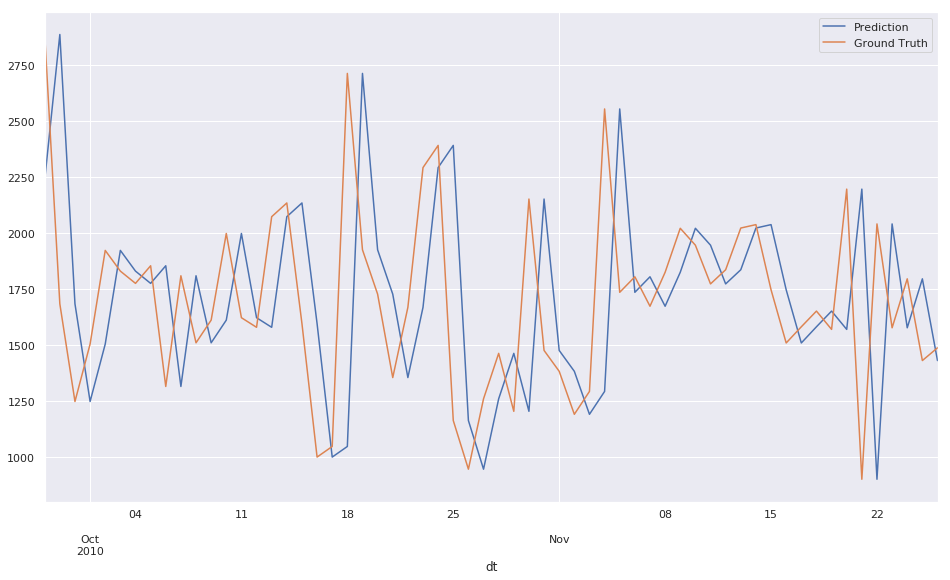

In [13]:
plot_prediction(df, prediction)

In [14]:
mean_absolute_error(df[1:], prediction.dropna())

391.6650402285138

## Скользящее среднее

In [15]:
prediction = df.rolling(7).apply(np.mean).shift(1)

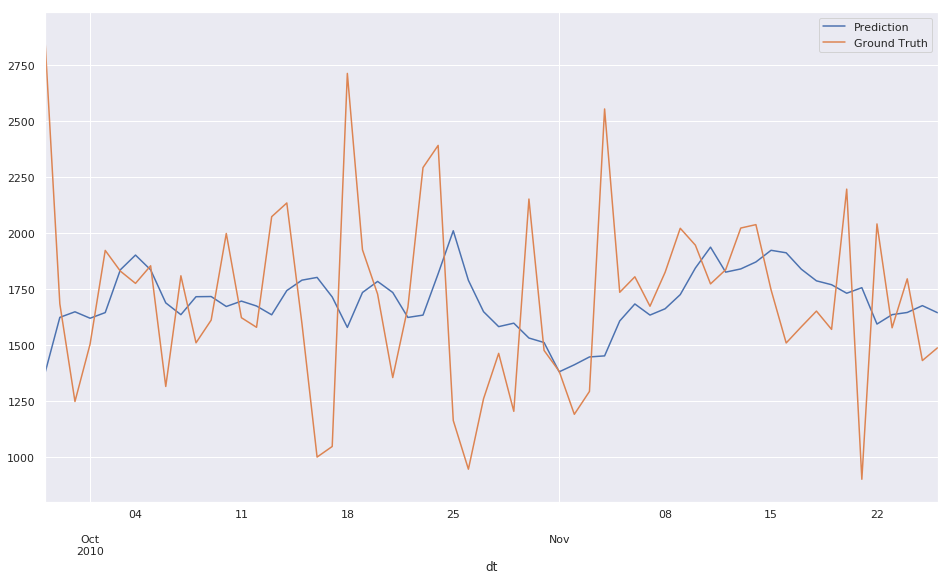

In [16]:
plot_prediction(df, prediction)

In [17]:
mean_absolute_error(df[7:], prediction.dropna())

328.0670773000717

In [18]:
def weighted_average(series, weights):
    if np.sum(weights) != 1:
        raise ValueError('Weights must sum to 1')
    weights.reverse()
    window_size = len(weights)
    w_fn = lambda x: np.sum(weights * x)
    return series.rolling(window_size).apply(w_fn)

prediction = weighted_average(df, [0.6, 0.2, 0.1, 0.07, 0.03])

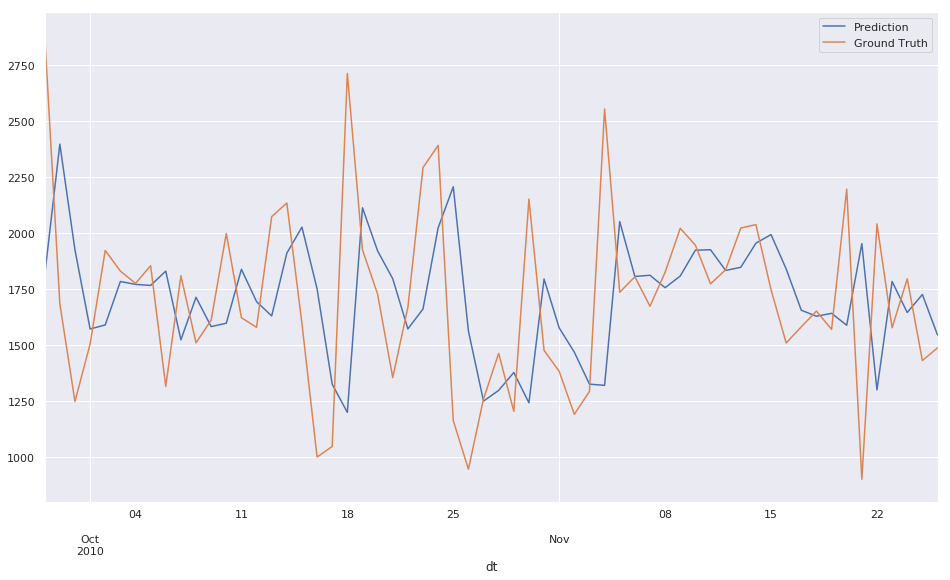

In [19]:
plot_prediction(df, prediction.shift(1))

In [20]:
mean_absolute_error(df[5:], prediction.shift(1).dropna())

344.06579028294635

## Экспоненциальные сглаживания

In [21]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.DataFrame(result, index=series.index)

In [22]:
prediction = exponential_smoothing(df, 0.7)

<Figure size 1152x648 with 0 Axes>

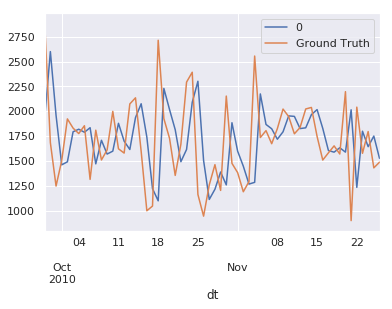

In [23]:
plot_prediction(df, prediction.shift(1))

In [24]:
mean_absolute_error(df[1:], prediction.shift(1).dropna())

356.87569238080096

# Fbprophet

Prophet был разработан для прогнозирования большого числа различных бизнес-показателей и строит достаточно хорошие default'ные прогнозы. Кроме того, он дает возможность, изменяя человеко-понятные параметры, улучшать прогноз и не требует от аналитиков глубоких знаний устройства предсказательных моделей.

Из минусов можно отметить достаточно небольшую точность предсказания "из коробки", для повышения качества придется повозиться с настройкой параметров.

[Статья](https://research.fb.com/prophet-forecasting-at-scale/) от Facebook про Prophet.  
[Ссылка](https://facebook.github.io/prophet/docs/quick_start.html) на официальную документацию.

In [25]:
from fbprophet import Prophet

Библиотека **Prophet** имеет интерфейс похожий на *sklearn*, сначала мы создаем модель, затем вызываем у нее метод *fit* для тренировки и *predict* для предсказания. На вход методу *fit* библиотека принимает *dataframe* с двумя колонками:

**ds** — время, поле должно быть типа date или datetime,  
**y** — числовой показатель, который мы хотим предсказывать.

In [26]:
df = data[['Global_active_power']].copy()
df = df.resample('D').apply(sum)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']

In [27]:
df.tail()

,ds,y
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164
1441,2010-11-26,1488.104


In [28]:
prediction_size = 31

df = data[['Global_active_power']].copy()
df = df.resample('D').apply(sum)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
df.tail()

,ds,y
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164
1441,2010-11-26,1488.104


In [29]:
train_df = df[:-prediction_size]

In [30]:
model = Prophet(daily_seasonality=True)
model.fit(train_df)

Для того что бы построить предсказания методу *predict* нужно передать *dataframe* с количеством записей, равным периоду, на который нужно предсказать.

In [31]:
future_dataframe = model.make_future_dataframe(periods=prediction_size, freq='D')
future_dataframe.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [32]:
forecast = model.predict(future_dataframe)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1437,2010-11-22,1256.592878,1453.284816,2555.116993,1256.519990,1256.664797,753.981302,753.981302,753.981302,347.387396,...,-130.351356,-130.351356,-130.351356,536.945263,536.945263,536.945263,0.0,0.0,0.0,2010.574180
1438,2010-11-23,1256.689284,1551.802341,2694.579875,1256.606500,1256.772823,870.111966,870.111966,870.111966,347.387396,...,-19.285752,-19.285752,-19.285752,542.010322,542.010322,542.010322,0.0,0.0,0.0,2126.801250
1439,2010-11-24,1256.785690,1586.105597,2633.750886,1256.694771,1256.876154,887.012466,887.012466,887.012466,347.387396,...,-3.948141,-3.948141,-3.948141,543.573212,543.573212,543.573212,0.0,0.0,0.0,2143.798156
1440,2010-11-25,1256.882096,1423.715646,2528.313795,1256.782077,1256.983635,728.828080,728.828080,728.828080,347.387396,...,-160.452695,-160.452695,-160.452695,541.893380,541.893380,541.893380,0.0,0.0,0.0,1985.710176
1441,2010-11-26,1256.978501,1547.360523,2645.439305,1256.868922,1257.095297,817.456432,817.456432,817.456432,347.387396,...,-67.231791,-67.231791,-67.231791,537.300828,537.300828,537.300828,0.0,0.0,0.0,2074.434933


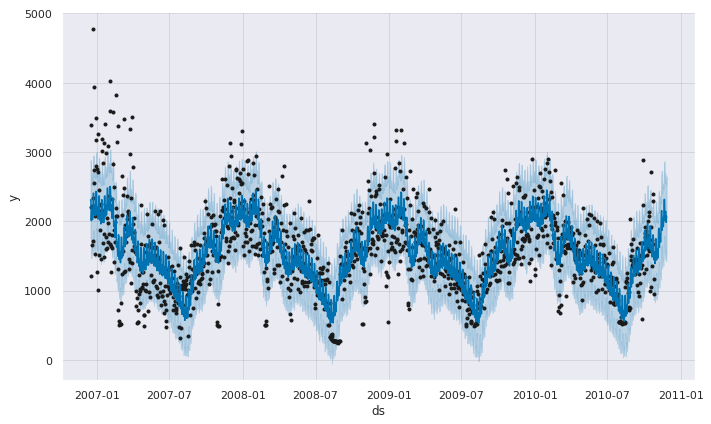

In [33]:
model.plot(forecast);

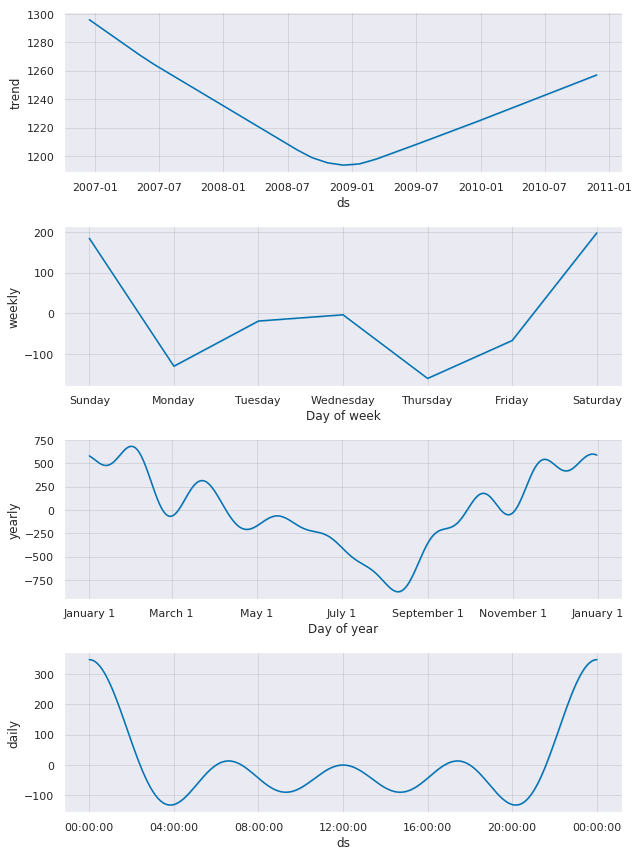

In [34]:
model.plot_components(forecast);

### Посчитаем ошибки прогноза:
MAPE (mean absolute percentage error) — это средняя абсолютная ошибка нашего прогноза. MAPE часто используется для оценки качества, поскольку эта величина относительная и по ней можно сравнивать качество даже на различных наборах данных.

$y_i$ - значение ряда в момент времени $i$.  
$\hat{y_i}$ - прогноз нашей модели в то же время.  

$e_i = y_i - \hat{y_i}$ - ошибка прогноза.  
$p_i = \frac{e_i}{y_i}$ - относительная ошибка прогноза.

$MAE = mean\space (\mid{e_i}\mid)$  
$MAPE = mean\space (\mid{p_i}\mid)$

In [35]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [36]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
       Return:
           tuple: (MAPE, MAE)
    """
    
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return error_mean('p'), error_mean('e')

In [37]:
cmp_df = make_comparison_dataframe(df, forecast)
mape, mae = calculate_forecast_errors(cmp_df, prediction_size)
print(f'MAPE = {mape},\nMAE = {mae}')

MAPE = 21.77352971197422,
MAE = 319.97705686656184


In [38]:
def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)

In [39]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='y'), title=title, showlegend=True)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [40]:
show_forecast(cmp_df, prediction_size, 140, 'Prediction')

## Преобразование Бокса-Кокса

Это монотонное преобразование для данных, которое обычно используется для стабилизации дисперсии. Подробнее [здесь.](https://en.wikipedia.org/wiki/Power_transform) 

Для исходной последовательности $y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$ однопараметрическое преобразование Бокса-Кокса с параметром $\lambda$ определяется следующим образом:

$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda-1}{\lambda},&\text{if } \lambda \neq 0,\\ \log{(y_i)},& \text{if } \lambda = 0.\end{cases}$

Параметр $\lambda$ можно выбирать, максимизируя логарифм правдоподобия. Еще один способ поиска оптимального значения параметра основан на поиске максимальной величины коэффициента корреляции между квантилями функции нормального распределения и отсортированной преобразованной последовательностью.

In [41]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [42]:
df_with_boxcox = df.copy().set_index('ds')
df_with_boxcox['y'], lambda_ = stats.boxcox(df_with_boxcox['y'])
df_with_boxcox.reset_index(inplace=True)

In [43]:
lambda_

0.6665092992069518

In [44]:
pd.concat([df_with_boxcox, df.y], axis=1).head()

,ds,y,y
0,2006-12-16,168.598628,1209.176
1,2006-12-17,336.676585,3390.460
2,2006-12-18,252.276815,2203.826
3,2006-12-19,209.121696,1666.194
4,2006-12-20,253.956562,2225.748


In [45]:
train_df_wb = df_with_boxcox[:-prediction_size]

model_wb = Prophet(daily_seasonality=True)
model_wb.fit(train_df_wb)

In [46]:
future_df_wb = model_wb.make_future_dataframe(periods=prediction_size, freq='D')
future_df_wb.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [47]:
forecast_wb = model_wb.predict(future_df_wb)
forecast_wb.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1437,2010-11-22,174.650488,191.209188,285.317856,174.643608,174.659438,63.445583,63.445583,63.445583,27.024764,...,-10.676995,-10.676995,-10.676995,47.097814,47.097814,47.097814,0.0,0.0,0.0,238.096071
1438,2010-11-23,174.660136,204.524669,296.110528,174.652180,174.669677,73.338574,73.338574,73.338574,27.024764,...,-1.315032,-1.315032,-1.315032,47.628842,47.628842,47.628842,0.0,0.0,0.0,247.998710
1439,2010-11-24,174.669783,200.374446,298.829882,174.661317,174.679832,74.976195,74.976195,74.976195,27.024764,...,0.106383,0.106383,0.106383,47.845048,47.845048,47.845048,0.0,0.0,0.0,249.645979
1440,2010-11-25,174.679431,191.928035,284.254680,174.670438,174.689957,61.412692,61.412692,61.412692,27.024764,...,-13.378964,-13.378964,-13.378964,47.766892,47.766892,47.766892,0.0,0.0,0.0,236.092123
1441,2010-11-26,174.689079,195.567943,291.390731,174.679135,174.700042,69.475486,69.475486,69.475486,27.024764,...,-4.970501,-4.970501,-4.970501,47.421223,47.421223,47.421223,0.0,0.0,0.0,244.164565


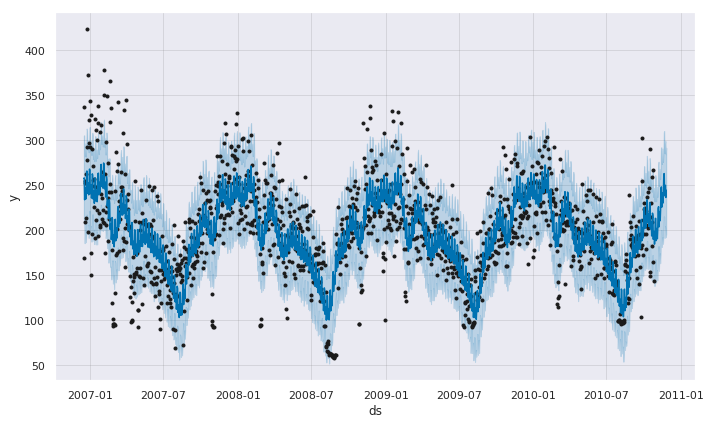

In [48]:
model_wb.plot(forecast_wb);

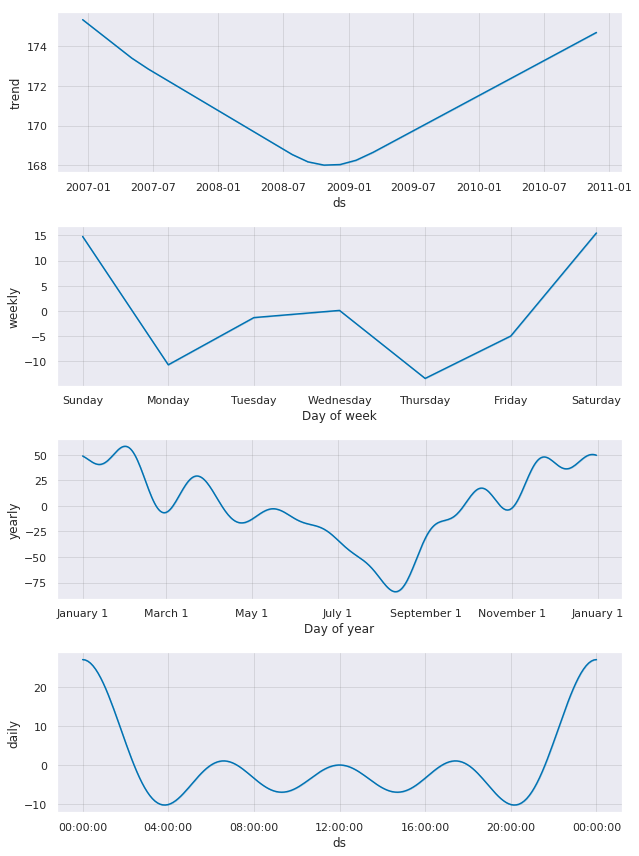

In [49]:
model_wb.plot_components(forecast_wb);

In [50]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_wb[column] = inverse_boxcox(forecast_wb[column], lambda_)

In [51]:
cmp_df_wb = make_comparison_dataframe(df, forecast_wb)
mape_wb, mae_wb = calculate_forecast_errors(cmp_df_wb, prediction_size)
print(f'MAPE = {mape:.2f}, MAPE with Box-Cox = {mape_wb:.2f}')
print(f'MAE = {mae:.2f}, MAE with Box-Cox = {mae_wb:.2f}')

MAPE = 21.77, MAPE with Box-Cox = 21.89
MAE = 319.98, MAE with Box-Cox = 322.91


In [52]:
show_forecast(cmp_df, prediction_size, 140, f'Prediction without transformation (MAPE = {mape:.2f})')
show_forecast(cmp_df_wb, prediction_size, 140, f'Prediction after Box-Cox (MAPE = {mape_wb:.2f})')

In [53]:
!mkdir ./models/fbprophet/
import pickle
with open('models/fbprophet/model_wb.pkl', 'wb') as f:
    pickle.dump(model_wb, f)

mkdir: cannot create directory ‘./models/fbprophet/’: File exists


# LightGBM

In [54]:
import lightgbm as lgb

**LightGBM** это одна из самых популярных библиотек для градиентного бустинга. Основные её преимущества в том, что она эффективна по памяти и действительно быстрая (бонусом идёт возможность работать с большими массивами данных и sparse матрицами).

[Ссылка](https://lightgbm.readthedocs.io/en/latest/) на официальную документацию.

In [55]:
def mean_encoding(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [56]:
def prepare_df(data, target_column, lag_start=1, lag_end=2, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for column in data.columns:
        for i in range(lag_start, lag_end):
            data[f"{column}_t-{i}"] = data[column].shift(i)
        if column != target_column:
            data.drop(column, axis=1, inplace=True)
        
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6]) * 1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data[f'{target_column}_weekday_average'] = list(map(mean_encoding(data[:test_index], 'weekday',
                                                                      target_column).get, data.weekday))
    data[f"{target_column}_hour_average"] = list(map(mean_encoding(data[:test_index], 'hour',
                                                                   target_column).get, data.hour))

    # выкидываем закодированные средними признаки
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target_column], axis=1)
    y_train = data.loc[:test_index][target_column]
    X_test = data.loc[test_index:].drop([target_column], axis=1)
    y_test = data.loc[test_index:][target_column]
    
    return X_train, X_test, y_train, y_test

## Таск: придумать признаки для модели

In [57]:
X_train, X_test, y_train, y_test = prepare_df(data.resample('h').mean(),
                                              "Global_active_power",
                                              lag_end=7,
                                              test_size=0.15)

In [58]:
X_train.head()

,Global_active_power_t-1,Global_active_power_t-2,Global_active_power_t-3,Global_active_power_t-4,Global_active_power_t-5,Global_active_power_t-6,Global_reactive_power_t-1,Global_reactive_power_t-2,Global_reactive_power_t-3,Global_reactive_power_t-4,...,Sub_metering_2_t-6,Sub_metering_3_t-1,Sub_metering_3_t-2,Sub_metering_3_t-3,Sub_metering_3_t-4,Sub_metering_3_t-5,Sub_metering_3_t-6,is_weekend,Global_active_power_weekday_average,Global_active_power_hour_average
0,2.200133,3.056467,3.268567,3.400233,3.632200,4.222889,0.056167,0.076667,0.075100,0.085233,...,0.527778,4.433333,17.216667,16.783333,16.683333,16.866667,16.861111,1,1.270925,0.911849
1,2.061600,2.200133,3.056467,3.268567,3.400233,3.632200,0.071433,0.056167,0.076667,0.075100,...,6.716667,0.000000,4.433333,17.216667,16.783333,16.683333,16.866667,1,1.250129,0.662140
2,1.882467,2.061600,2.200133,3.056467,3.268567,3.400233,0.102433,0.071433,0.056167,0.076667,...,1.433333,0.000000,0.000000,4.433333,17.216667,16.783333,16.683333,1,1.250129,0.536781
3,3.349400,1.882467,2.061600,2.200133,3.056467,3.268567,0.136933,0.102433,0.071433,0.056167,...,0.000000,0.000000,0.000000,0.000000,4.433333,17.216667,16.783333,1,1.250129,0.476119
4,1.587267,3.349400,1.882467,2.061600,2.200133,3.056467,0.078233,0.136933,0.102433,0.071433,...,0.416667,0.000000,0.000000,0.000000,0.000000,4.433333,17.216667,1,1.250129,0.445037


In [59]:
# Логарифмируем таргет (частный случай преобразования Бокса-Кокса)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [60]:
lgb_train = lgb.Dataset(X_train, y_train_log)
lgb_test = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

In [61]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.005,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                verbose_eval=False,
                valid_sets=lgb_test,
                num_boost_round=10000,
                early_stopping_rounds=50)

## Таск: реализовать функции для подсчёта MAE, MAPE

In [62]:
def mean_abs_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [63]:
def mean_abs_percentage_error(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
# Не забываем про обратное преобразование
y_pred = np.exp(gbm.predict(X_test))

# Сравним с наивным бейзлайном "завтра будет так же, как сегодня"
y_naive_pred = y_test.shift(1)

print(f'GBM MAE = {mean_abs_error(y_test, y_pred)}')
print(f'GBM MAPE = {mean_abs_percentage_error(y_test, y_pred)}\n')
print(f'Naïve MAE = {mean_abs_error(y_test, y_naive_pred)}')
print(f'Naïve MAPE = {mean_abs_percentage_error(y_test, y_naive_pred)}')

GBM MAE = 0.29329414120816744
GBM MAPE = 33.835129928517574

Naïve MAE = 0.37262652424883336
Naïve MAPE = 44.779014885699596


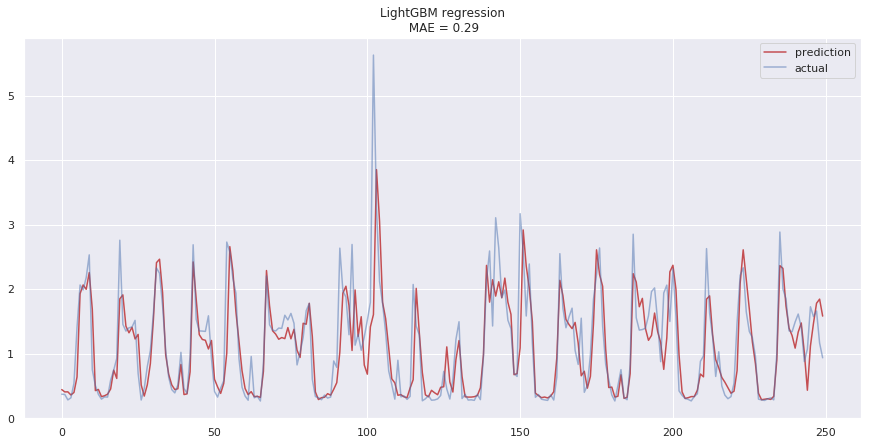

In [65]:
plt.figure(figsize=(15, 7))
plt.plot(y_pred[-250:], "r", label="prediction")
plt.plot(y_test.values[-250:], label="actual", alpha=0.5)
plt.legend(loc="best")
plt.title(f"LightGBM regression\n MAE = {mean_abs_error(y_test, y_pred):.2f}")
plt.grid(True);

In [127]:
!mkdir -p ./models/light_gmb_h_mean/
gbm.save_model('models/light_gmb_h_mean/weights.gbm')

### Дублируем то же самое на дневных суммах и дневных средних

In [131]:
def train_lgb(dataset):
    X_train, X_test, y_train, y_test = prepare_df(dataset,
                                                  "Global_active_power",
                                                  lag_end=7,
                                                  test_size=0.15)
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)

    lgb_train = lgb.Dataset(X_train, y_train_log)
    lgb_test = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'learning_rate': 0.005,
        'verbose': 0
    }

    gbm = lgb.train(params,
                    lgb_train,
                    verbose_eval=False,
                    valid_sets=lgb_test,
                    num_boost_round=10000,
                    early_stopping_rounds=50)
    # Не забываем про обратное преобразование
    y_pred = np.exp(gbm.predict(X_test))

    # Сравним с наивным бейзлайном "завтра будет так же, как сегодня"
    y_naive_pred = y_test.shift(1)

    print(f'GBM MAE = {mean_abs_error(y_test, y_pred)}')
    print(f'GBM MAPE = {mean_abs_percentage_error(y_test, y_pred)}\n')
    print(f'Naïve MAE = {mean_abs_error(y_test, y_naive_pred)}')
    print(f'Naïve MAPE = {mean_abs_percentage_error(y_test, y_naive_pred)}')
    plt.figure(figsize=(15, 7))
    plt.plot(y_pred[-250:], "r", label="prediction")
    plt.plot(y_test.values[-250:], label="actual", alpha=0.5)
    plt.legend(loc="best")
    plt.title(f"LightGBM regression\n MAE = {mean_abs_error(y_test, y_pred):.2f}")
    plt.grid(True);
    return gbm

GBM MAE = 0.170718252727682
GBM MAPE = 18.913392248093587

Naïve MAE = 0.19589340122864843
Naïve MAPE = 20.018929806889034


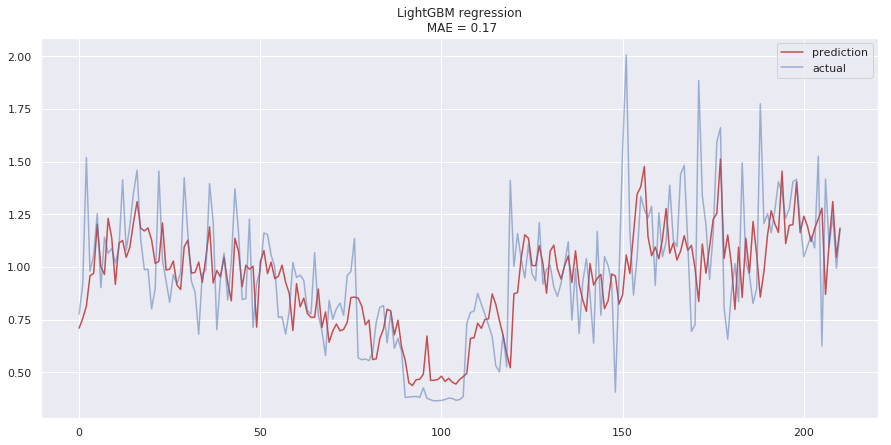

In [134]:
gbm = train_lgb(data.resample('D').mean())
!mkdir -p ./models/light_gmb_h_mean/
gbm.save_model('models/light_gmb_h_mean/weights.gbm')

GBM MAE = 246.44262082982638
GBM MAPE = 19.277422429811345

Naïve MAE = 281.0934185248244
Naïve MAPE = 19.962637687670366


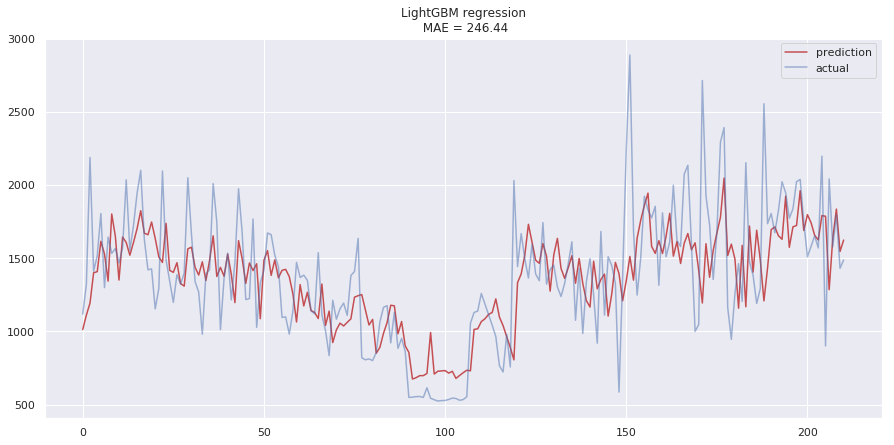

In [135]:
gbm = train_lgb(data.resample('D').sum())
!mkdir -p ./models/light_gmb_h_sum/
gbm.save_model('models/light_gmb_h_sum/weights.gbm')

# ARIMA

## Краткая теория по временным рядам

В классических задачах анализа данных предполагается что все наблюдение независимы, однако при прогнозировании временных рядов, мы наоборот, надеемся, что значения ряда в прошлом содержат информацию о его поведении в будущем.

### Компоненты временных рядов:

**Тренд** — плавное долгосрочное изменение уровня ряда.  
**Сезонность** — циклические изменения уровня ряда с постоянным
периодом.  
**Цикл** — изменения уровня ряда с переменным периодом (экономические
циклы, периоды солнечной активности).  
**Ошибка** — непрогнозируемая случайная компонента ряда.


### Стационарность:

Под [**стационарностью**](https://ru.wikipedia.org/wiki/Стационарность) понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями).

Для нас это означает, что временные ряды с трендом и сезонностью - нестационарны. Цикличность, тем не менее, оставляет ряд стационарным, потому что нельзя заранее предсказать, где будут находиться минимумы или максимумы ряда.  

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Бороться с нестационарностью можно множеством способов - дифференцированием, выделением тренда и сезонности, сглаживаниями и различными преобразованиями (логарифмирование, Бокс-Кокс).

Формально проверить гипотезу о стационарности ряда можно с помощью теста [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера). Однако всегда нужно смотреть на ряд глазами, потому что тесты в ряде случаях могут ошибаться. 

## Таск: Какие из представленных ниже временных рядов стационарны?

<img src="./images/download.png"/>

Знаменитая картинка из [лекции](https://www.youtube.com/watch?v=u433nrxdf5k) Евгения Рябенко о временных рядах. 

## Модель

Немного о модели: [ARIMA](https://ru.wikipedia.org/wiki/ARIMA) (autoregressive integrated moving average). Существует [теорема Вольда](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%92%D0%BE%D0%BB%D0%B4%D0%B0), которая говорит о том, что любой стационарный ряд может быть описан моделью ARIMA, а это значит, что наша задача в первую очередь привести ряд к стационарному виду, после чего производить моделирование.

Формула для просчёта выборочной автокорреляции  

$$\hat{\rho}_k = \frac{\sum_{t=k+1}^{T}(y_t - \bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^{T}(y_t - \bar{y})^2} $$


Формула для просчёта выборочной частичной автокорреляции  

$$\hat{y}_t = * + * \cdot y_{t-1} + * \cdot y_{t_2} + \cdots + * \cdot y_{t-k+1} + \phi_{k} \cdot y_{t-k} + u_t$$

In [67]:
import patsy
import statsmodels.api as sm

In [68]:
df = data[['Global_active_power']].resample('D').apply(np.mean)
df.head()

,Global_active_power
dt,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


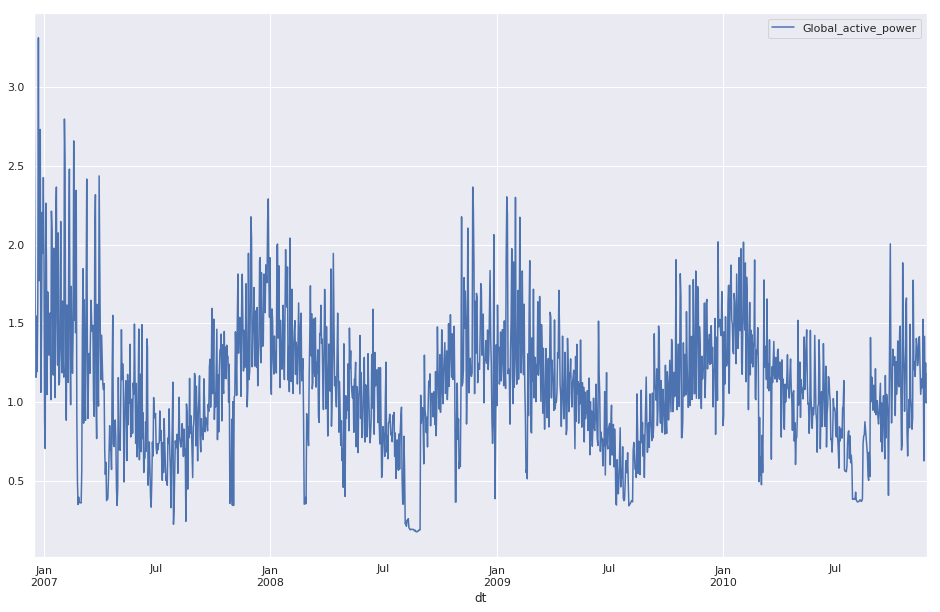

In [69]:
df.plot(figsize=(16, 10));

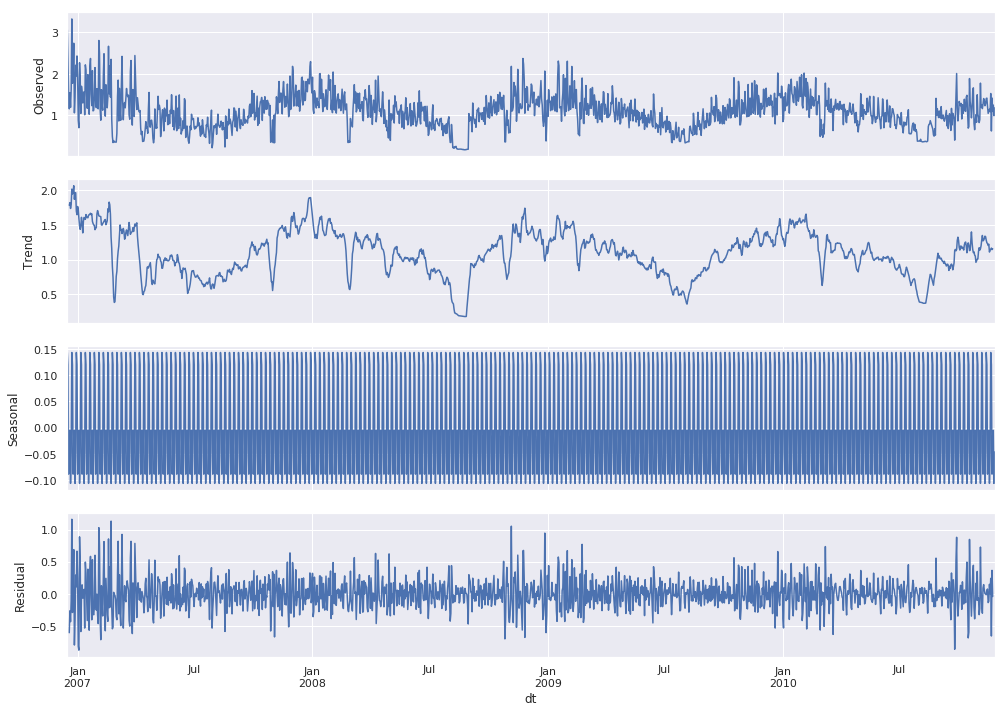

Критерий Дики-Фуллера: p=0.004304


In [70]:
from pylab import rcParams
rcParams['figure.figsize'] = (14, 10)

decomposition = sm.tsa.seasonal_decompose(df['Global_active_power'])
fig = decomposition.plot()
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power'])[1])

Критерий Дики-Фуллера: p=0.000317


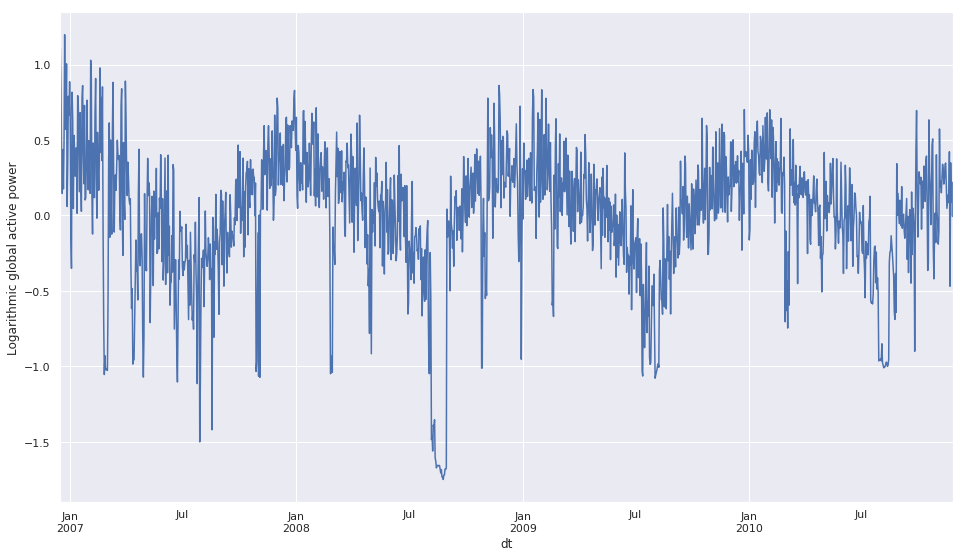

In [72]:
df['Global_active_power_log'] = np.log(df['Global_active_power'])
df['Global_active_power_log'].plot(figsize=(16, 9));
plt.ylabel(u'Logarithmic global active power')

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log'])[1])

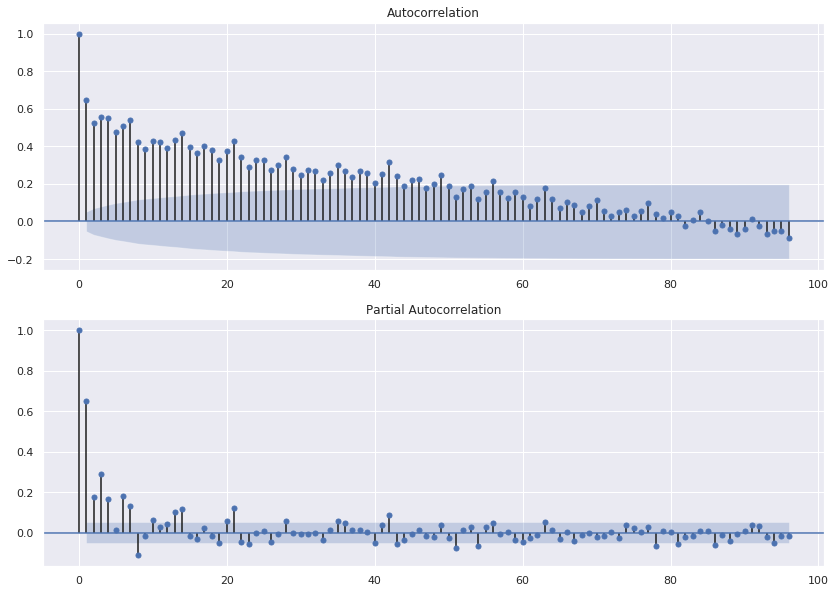

In [73]:
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_box'].dropna().values.squeeze(), lags=96, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_box'].dropna().values.squeeze(), lags=96, ax=ax)
plt.show()

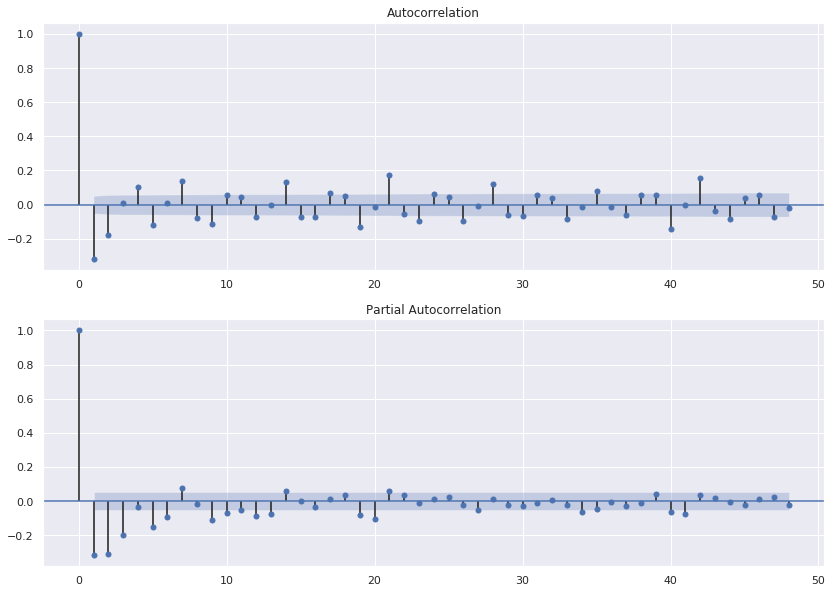

Критерий Дики-Фуллера: p=0.000000


In [74]:
df['Global_active_power_log_diff'] = df['Global_active_power_log'] - df['Global_active_power_log'].shift(1)

ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_log_diff'].dropna().values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_log_diff'].dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log_diff'].dropna())[1])

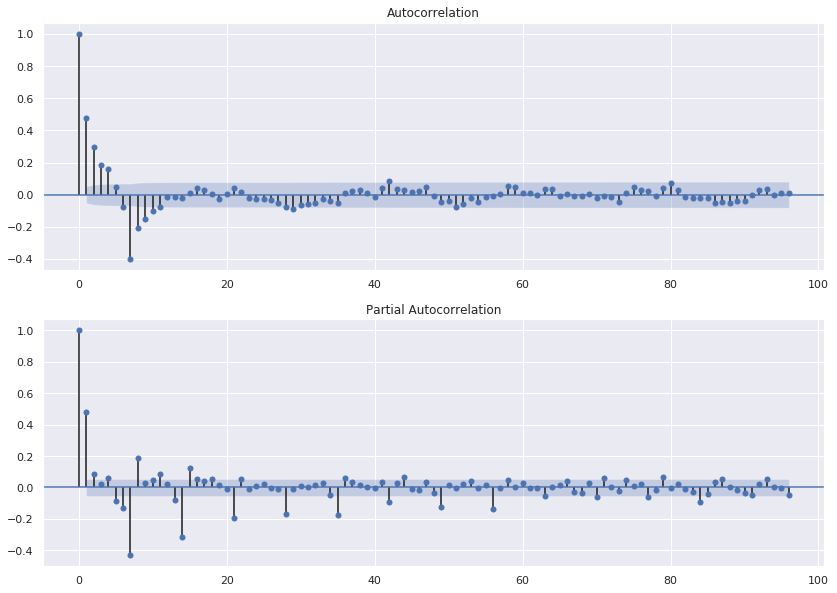

Критерий Дики-Фуллера: p=0.000000


In [75]:
df['Global_active_power_log_week'] = df['Global_active_power_log'] - df['Global_active_power_log'].shift(7)
df['Global_active_power_log_diff_week'] = df['Global_active_power_log_week'] - df['Global_active_power_log_week'].shift(1)

ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_log_week'].dropna().values.squeeze(), lags=96, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_log_week'].dropna().values.squeeze(), lags=96, ax=ax)
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log_week'].dropna())[1])

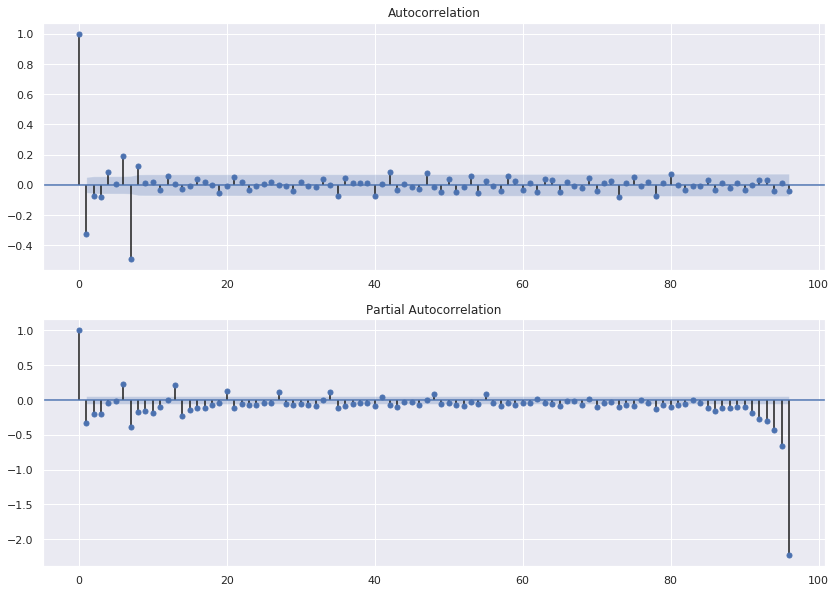

Критерий Дики-Фуллера: p=0.000000


In [76]:
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_log_diff_week'].dropna().values.squeeze(), lags=96, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_log_diff_week'].dropna().values.squeeze(), lags=96, ax=ax)
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log_diff_week'].dropna())[1])

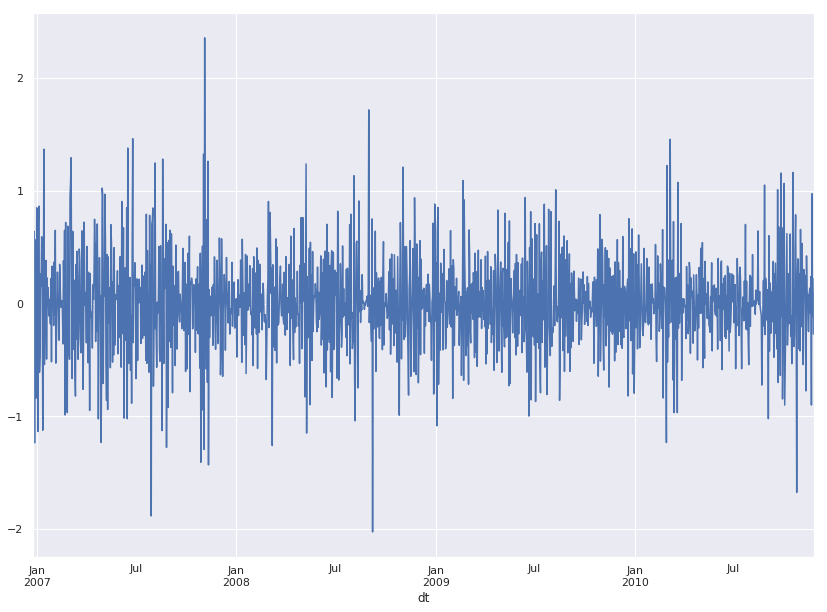

In [77]:
df['Global_active_power_log_diff_week'].dropna().plot()

In [92]:
ps, Ps = range(4, 7), range(0, 3)
qs, Qs = range(4, 7), range(0, 1)
d, D = 1, 1
lag = 7

In [79]:
day_ns = df['Global_active_power_log'].index.dayofyear
day_ns

Int64Index([350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
            ...
            321, 322, 323, 324, 325, 326, 327, 328, 329, 330],
           dtype='int64', name='dt', length=1442)

In [80]:
exog_season = patsy.dmatrix('bs(day_ns, df=8)')
print(exog_season.shape)
print(exog_season[:5])

exog_season2 = exog_season[:, 1:]  # bug/requirement: no constant in exog

(1442, 9)
[[1.         0.         0.         0.         0.         0.00272499
  0.08000936 0.48886692 0.42839873]
 [1.         0.         0.         0.         0.         0.00224532
  0.07111799 0.47147055 0.45516614]
 [1.         0.         0.         0.         0.         0.00182553
  0.06264618 0.45250235 0.48302594]
 [1.         0.         0.         0.         0.         0.00146162
  0.05461518 0.4319232  0.512     ]
 [1.         0.         0.         0.         0.         0.0011496
  0.04704626 0.40969399 0.54211015]]


In [81]:
train_portion = 31
train_df, test_df = df[:-train_portion], df[-train_portion:]
train_exog, test_exog = exog_season2[:-train_portion], exog_season2[-train_portion:]

In [93]:
import itertools
import warnings

parameters = itertools.product(ps, qs, Ps, Qs)
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for parameter in list(parameters):
    # Модель обучается не на всех наборах параметров
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['Global_active_power_log'], 
                                        order=(parameter[0], d, parameter[1]), 
                                        seasonal_order=(parameter[2], D, parameter[3], lag),
                                        exog=exog_season2[:-31]).fit(disp=-1)
    # Выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError as e:
        print('wrong parameters:', parameter)
        continue
    aic = model.aic
    # Сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_parameter = parameter
    results.append([parameter, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (6, 4, 0, 0)
wrong parameters: (6, 4, 1, 0)
wrong parameters: (6, 4, 2, 0)


In [94]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
20,"(6, 5, 2, 0)",521.855492
14,"(5, 5, 2, 0)",549.671139
19,"(6, 5, 1, 0)",573.167972
13,"(5, 5, 1, 0)",582.213225
23,"(6, 6, 2, 0)",583.456910


/home/control/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



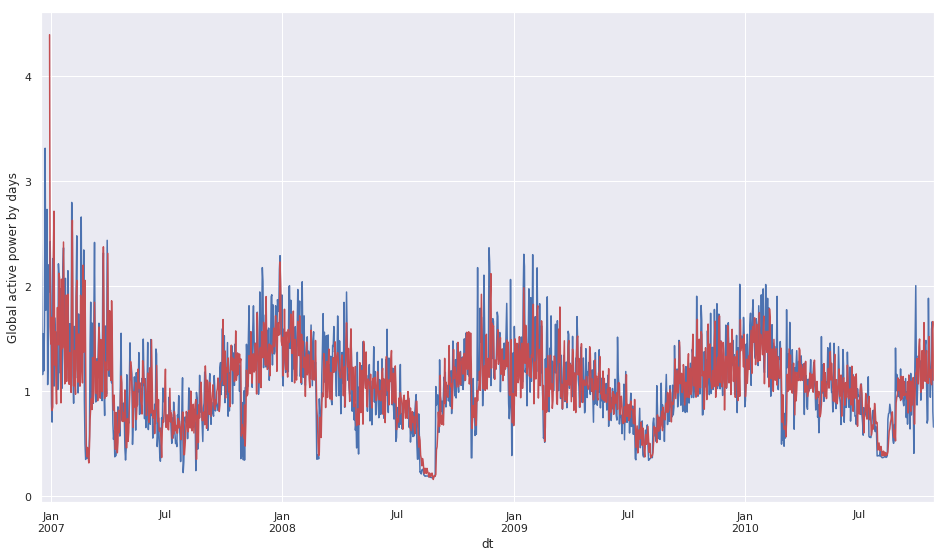

In [96]:
train_df['model'] = np.exp(best_model.fittedvalues)
plt.figure(figsize=(16, 9))
train_df['Global_active_power'].plot()
train_df['model'].dropna()[14:].plot(color='r')
plt.ylabel('Global active power by days')
plt.show()

In [99]:
pred_values = np.exp(best_model.forecast(31, exog=exog_season2[16+330:16+330+31, :]))

/home/control/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



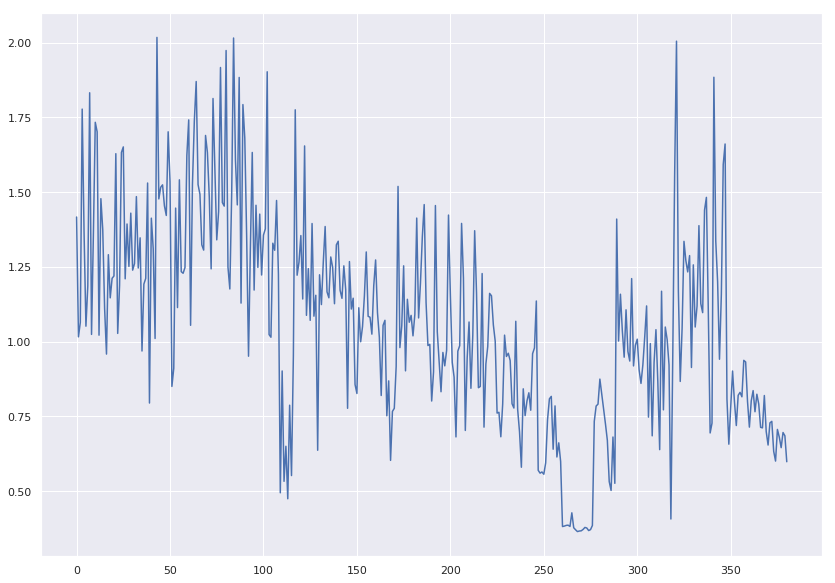

In [100]:
plt.plot(np.concatenate([train_df['Global_active_power'].values[-350:], pred_values]));

Критерий Стьюдента: p=0.614971
Критерий Дики-Фуллера: p=0.000000


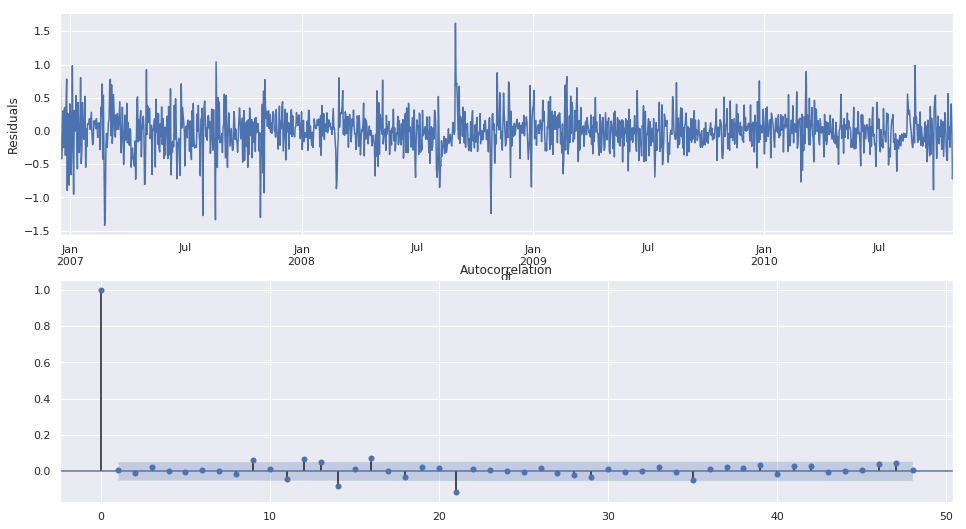

In [101]:
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
best_model.resid.dropna().plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid.dropna(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid.dropna())[1])

In [102]:
mean_abs_error(pred_values, test_df['Global_active_power'].values)

0.42680826439778535

In [103]:
mean_abs_percentage_error(pred_values, test_df['Global_active_power'].values)

58.950683796296865

In [104]:
sarima_folder = os.path.join('models', 'sarima')
!mkdir -p {sarima_folder}

In [105]:
best_model.save(os.path.join(sarima_folder, 'model.sa'))

# LSTM

**LSTM - Long-Short-term Memory**

Данный вид рекуррентных нейронных сетей позволяет сохранять как длительные, так и коротковременные зависимости в последовательностях данных. Это происходит за счёт особой архитектуры сети, которую вы можете увидеть ниже
<img src='./images/LSTM.png'>
*Картинка взята из замечательной [статьи об устройстве LSTM и GRU](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)*

В каждой ячейке имеется вход новых данных и вход предыдущего состояния. А также ячейка имеет свое "состояние", благодаря которому сеть и "запоминает" данные.  

$$f = \sigma(W_f [h_{t-1}; x_t] + b_f)$$  
$$i = \sigma(W_i [h_{t-1}; x_t] + b_i)$$  
$$o = \sigma(W_o [h_{t-1}; x_t] + b_o)$$  

$$\tilde c_{t} = tanh(W_h [h_{t-1}; x_t] + b_h)$$  
$$c_t = f \odot c_{t-1} + i \odot \tilde c_t$$  

$$h_t = o \odot tanh(c_t)$$

In [106]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [107]:
df_resample = data.resample('h').mean() 
df_resample.shape

(34589, 7)

In [108]:
values = df_resample.values 

In [115]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [116]:
reframed = series_to_supervised(scaled, 7, 1)

reframed.drop(reframed.columns[50:], axis=1, inplace=True)
print(reframed.head())

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
8    0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
9    0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
10   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
11   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

    var7(t-7)  var1(t-6)  var2(t-6)  var3(t-6)  ...  var6(t-2)  var7(t-2)  \
7    0.687521   0.545045   0.103358   0.335501  ...   0.002872   0.180772   
8    0.687748   0.509006   0.110073   0.283802  ...   0.001795   0.000000   
9    0.680272   0.488550   0.096987   0.315987  ...   0.010050   0.000000   
10   0.684350   0.455597   0.099010   0.434417  ...   0.543431   0.000000   
11   0.702019   0.322555   0.072536   0.495847  ...   0.012204   0.000000   

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
7    0.301032   0.092251   0.567

In [117]:
values = reframed.values

n_train_time = 365*24*3
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 7, 7))
test_X = test_X.reshape((test_X.shape[0], 7, 7))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(26280, 7, 7) (26280,) (8302, 7, 7) (8302,)


In [118]:
model = Sequential()
model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/control/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 26280 samples, validate on 8302 samples
Epoch 1/20
 - 9s - loss: 0.1065 - val_loss: 0.0844
Epoch 2/20
 - 5s - loss: 0.0882 - val_loss: 0.0701
Epoch 3/20
 - 5s - loss: 0.0799 - val_loss: 0.0663
Epoch 4/20
 - 5s - loss: 0.0772 - val_loss: 0.0666
Epoch 5/20
 - 5s - loss: 0.0750 - val_loss: 0.0651
Epoch 6/20
 - 5s - loss: 0.0737 - val_loss: 0.0634
Epoch 7/20
 - 5s - loss: 0.0734 - val_loss: 0.0637
Epoch 8/20
 - 6s - loss: 0.0730 - val_loss: 0.0630
Epoch 9/20
 - 6s - loss: 0.0723 - val_loss: 0.0627
Epoch 10/20
 - 5s - loss: 0.0717 - val_loss: 0.0624
Epoch 11/20
 - 5s - loss: 0.0715 - val_loss: 0.0617
Epoch 12/20
 - 5s - loss: 0.0711 - val_loss: 0.0620
Epoch 13/20
 - 5s - loss: 0.0708 - val_loss: 0.0610
Epoch 14/20
 - 5s - loss: 0.0706 - val_loss: 0.0610
Epoch 15/20
 - 6s - loss: 0.0707 - val_loss: 0.0605
Epoch 16/20
 - 7s - loss: 0.0703 - val_loss: 0.0609
Epoch 17/20
 - 5s - loss: 0.0704 - val_loss: 0.0610
Epoch 18/20
 - 5s - loss: 0.0700 - val_loss: 0.0603
Epoch 19/20
 - 7s - loss

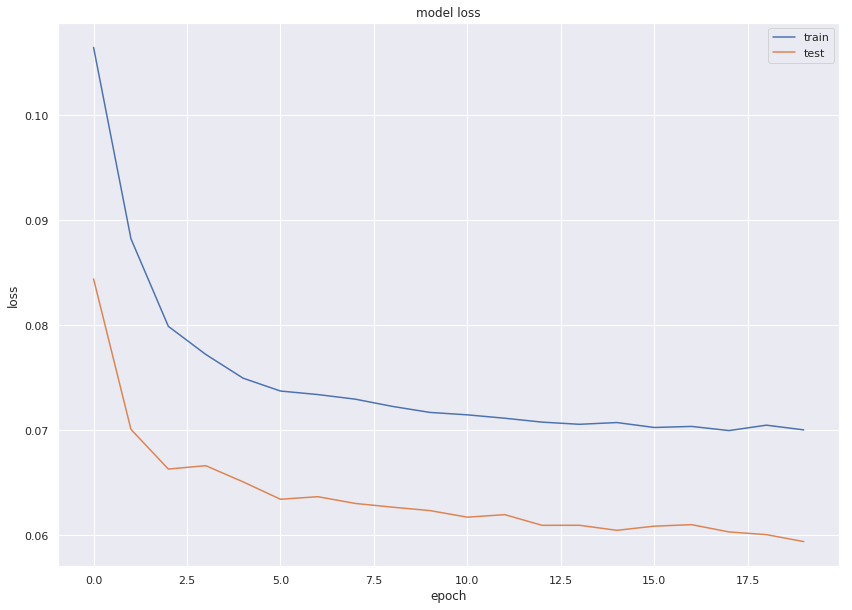

In [119]:
history = model.fit(train_X, train_y, epochs=20, batch_size=70,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [120]:
# make a prediction
yhat = model.predict(test_X)
test_X_ = test_X[:, 0, :]
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.535


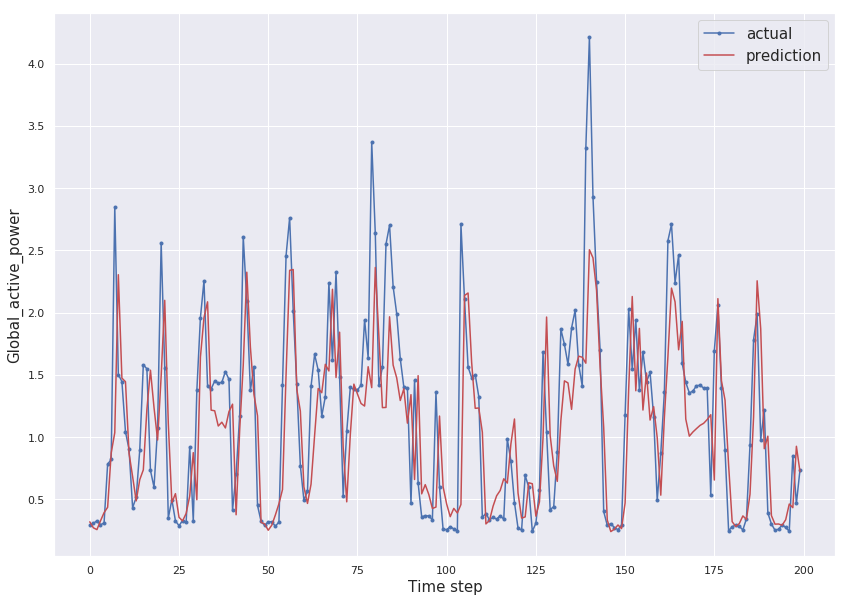

In [121]:
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

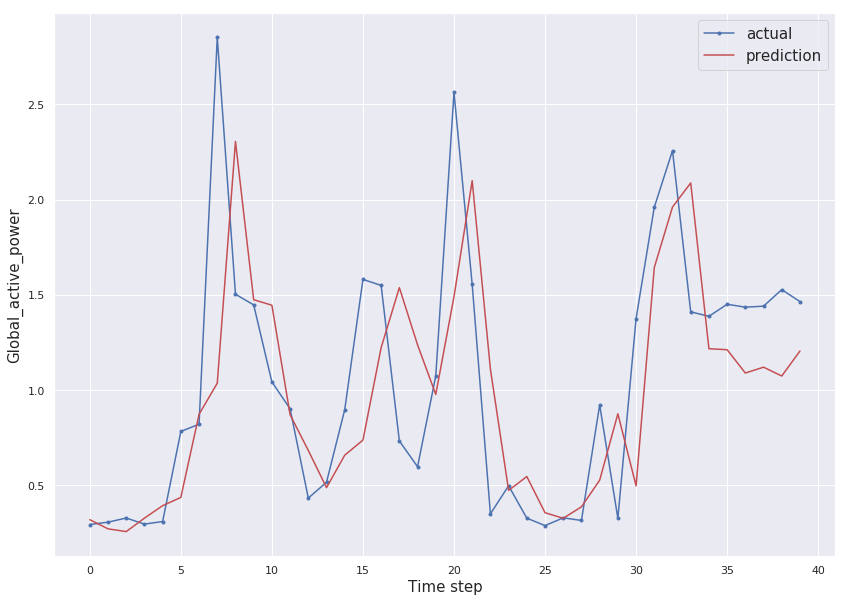

In [122]:
aa=[x for x in range(40)]
plt.plot(aa, inv_y[:40], marker='.', label="actual")
plt.plot(aa, inv_yhat[:40], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [123]:
print(f'GBM MAE = {mean_abs_error(inv_y, inv_yhat)}')
print(f'GBM MAPE = {mean_abs_percentage_error(inv_y, inv_yhat)}\n')

GBM MAE = 0.38233593225194
GBM MAPE = 49.03685012097964



In [124]:
model_folder = os.path.join('models', 'lstm_keras_h')
model_json_path = os.path.join(model_folder, 'model.json')
weights_path = os.path.join(model_folder, 'weights.hd5')
scaler_path = os.path.join(model_folder, 'scaler.pkl')

In [125]:
!mkdir -p {model_folder}

In [126]:
with open(model_json_path, 'w') as f:
    json.dump(model.to_json(), f)
model.save_weights(weights_path)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

In [144]:
def train_lstm(dataset, n_train_time):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(dataset)
    
    reframed = series_to_supervised(scaled, 7, 1)
    reframed.drop(reframed.columns[50:], axis=1, inplace=True)
    values = reframed.values

    train = values[:n_train_time, :]
    test = values[n_train_time:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 7, 7))
    test_X = test_X.reshape((test_X.shape[0], 7, 7))

    model = Sequential()
    model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(20, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(10))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    history = model.fit(train_X, train_y, epochs=20, batch_size=70,
                        validation_data=(test_X, test_y), verbose=2, shuffle=False)

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    yhat = model.predict(test_X)
    test_X_ = test_X[:, 0, :]
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X_[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X_[:, -6:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    
    aa=[x for x in range(200)]
    plt.plot(aa, inv_y[:200], marker='.', label="actual")
    plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
    plt.ylabel('Global_active_power', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()
    
    print(f'GBM MAE = {mean_abs_error(inv_y, inv_yhat)}')
    print(f'GBM MAPE = {mean_abs_percentage_error(inv_y, inv_yhat)}\n')
    
    return model, scaler

Train on 1095 samples, validate on 340 samples
Epoch 1/20
 - 4s - loss: 0.1856 - val_loss: 0.0767
Epoch 2/20
 - 0s - loss: 0.1343 - val_loss: 0.0791
Epoch 3/20
 - 0s - loss: 0.1262 - val_loss: 0.0770
Epoch 4/20
 - 0s - loss: 0.1202 - val_loss: 0.0741
Epoch 5/20
 - 0s - loss: 0.1177 - val_loss: 0.0723
Epoch 6/20
 - 0s - loss: 0.1141 - val_loss: 0.0718
Epoch 7/20
 - 0s - loss: 0.1094 - val_loss: 0.0694
Epoch 8/20
 - 0s - loss: 0.1084 - val_loss: 0.0676
Epoch 9/20
 - 0s - loss: 0.1057 - val_loss: 0.0704
Epoch 10/20
 - 0s - loss: 0.1045 - val_loss: 0.0677
Epoch 11/20
 - 0s - loss: 0.1031 - val_loss: 0.0676
Epoch 12/20
 - 0s - loss: 0.1004 - val_loss: 0.0680
Epoch 13/20
 - 0s - loss: 0.0990 - val_loss: 0.0707
Epoch 14/20
 - 0s - loss: 0.0963 - val_loss: 0.0652
Epoch 15/20
 - 0s - loss: 0.0986 - val_loss: 0.0708
Epoch 16/20
 - 0s - loss: 0.0983 - val_loss: 0.0715
Epoch 17/20
 - 0s - loss: 0.0957 - val_loss: 0.0651
Epoch 18/20
 - 0s - loss: 0.0943 - val_loss: 0.0697
Epoch 19/20
 - 0s - loss: 

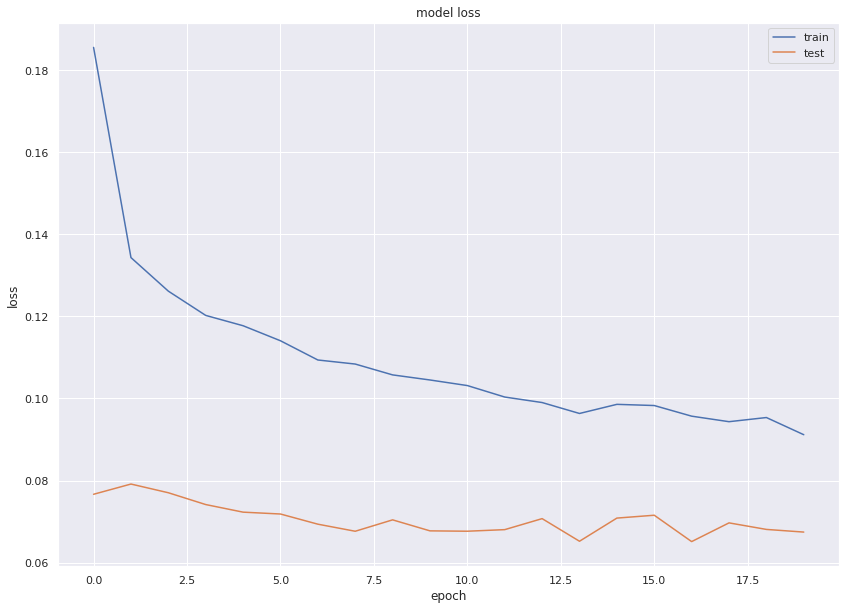

Test RMSE: 0.276


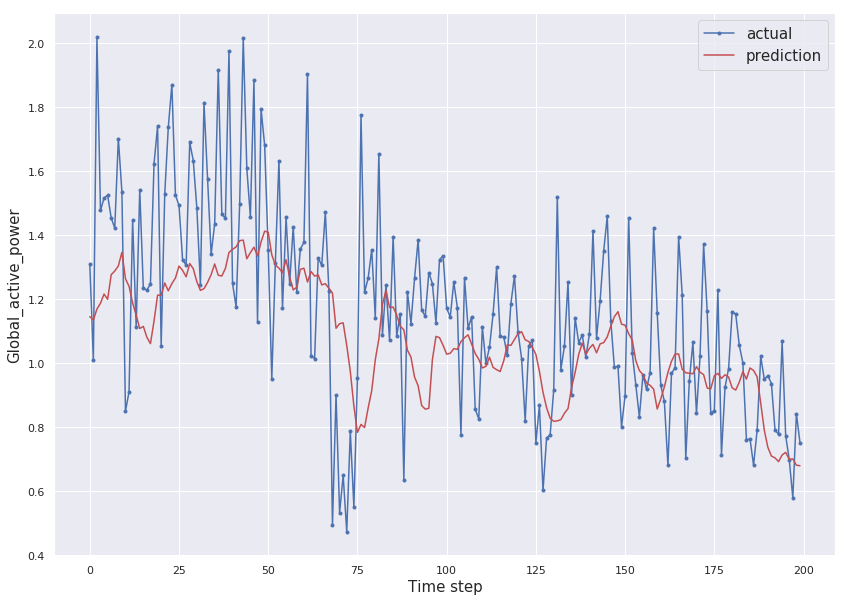

GBM MAE = 0.21182528305048967
GBM MAPE = 21.648871367927676



In [145]:
model, scaler = train_lstm(data.resample('d').mean(), 365*3)

In [146]:
def save_model(model, scaler, folder_name):
    model_folder = os.path.join('models', folder_name)
    model_json_path = os.path.join(model_folder, 'model.json')
    weights_path = os.path.join(model_folder, 'weights.hd5')
    scaler_path = os.path.join(model_folder, 'scaler.pkl')

    !mkdir -p {model_folder}

    with open(model_json_path, 'w') as f:
        json.dump(model.to_json(), f)
    model.save_weights(weights_path)

    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

In [147]:
save_model(model, scaler, 'lstm_keras_d_mean')

Train on 1095 samples, validate on 340 samples
Epoch 1/20
 - 4s - loss: 0.1856 - val_loss: 0.0838
Epoch 2/20
 - 0s - loss: 0.1314 - val_loss: 0.0874
Epoch 3/20
 - 0s - loss: 0.1245 - val_loss: 0.0745
Epoch 4/20
 - 0s - loss: 0.1170 - val_loss: 0.0754
Epoch 5/20
 - 0s - loss: 0.1104 - val_loss: 0.0702
Epoch 6/20
 - 0s - loss: 0.1085 - val_loss: 0.0744
Epoch 7/20
 - 0s - loss: 0.1064 - val_loss: 0.0661
Epoch 8/20
 - 0s - loss: 0.1025 - val_loss: 0.0673
Epoch 9/20
 - 0s - loss: 0.1050 - val_loss: 0.0656
Epoch 10/20
 - 0s - loss: 0.1007 - val_loss: 0.0657
Epoch 11/20
 - 0s - loss: 0.1033 - val_loss: 0.0710
Epoch 12/20
 - 0s - loss: 0.1003 - val_loss: 0.0662
Epoch 13/20
 - 0s - loss: 0.1003 - val_loss: 0.0660
Epoch 14/20
 - 0s - loss: 0.0989 - val_loss: 0.0682
Epoch 15/20
 - 0s - loss: 0.0963 - val_loss: 0.0654
Epoch 16/20
 - 0s - loss: 0.0979 - val_loss: 0.0697
Epoch 17/20
 - 0s - loss: 0.0974 - val_loss: 0.0661
Epoch 18/20
 - 0s - loss: 0.0958 - val_loss: 0.0656
Epoch 19/20
 - 0s - loss: 

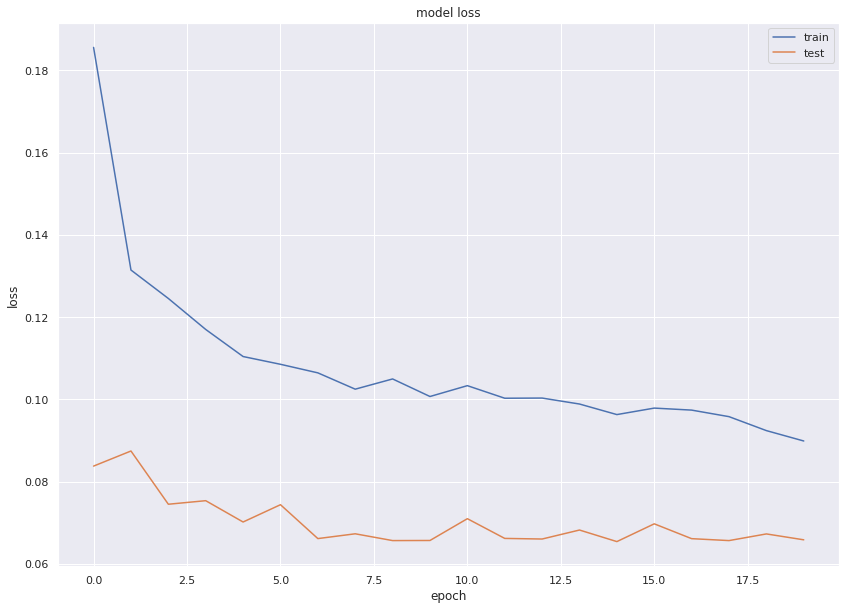

Test RMSE: 393.063


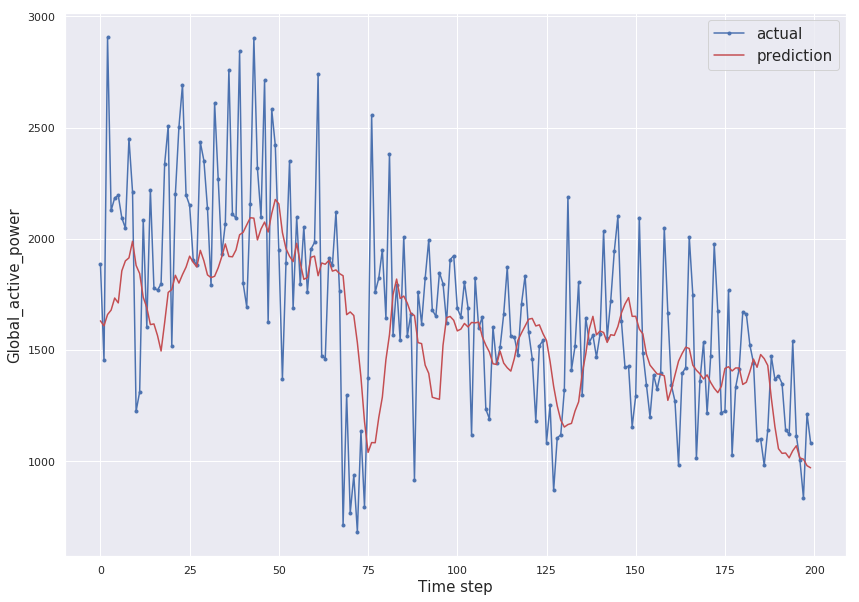

GBM MAE = 297.7835503553378
GBM MAPE = 21.06971090521701



In [148]:
model, scaler = train_lstm(data.resample('d').sum(), 365*3)

In [149]:
save_model(model, scaler, 'lstm_keras_d_sum')